In [35]:
import nengo
import numpy as np
import math
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.processes import Piecewise
from nengo.dists import Uniform

def inverse_kinematics_numeric(L = [1, 1, 1], neurons_per_rad = 200, adaptation_rate=0.08):

    model = nengo.Network()
    
    with model:
        
        NORMALIZE_FACTOR = 1000
        END_EFFECTOR_COORIDINATES_TOLERANCE = 0.001 / NORMALIZE_FACTOR 
        inter = .3
        
        l1 = float(L[0]) / NORMALIZE_FACTOR
        l2 = float(L[1]) / NORMALIZE_FACTOR
        l3 = float(L[2]) / NORMALIZE_FACTOR
        
        #l1 = L[0]
        #l2 = L[1]
        #l3 = L[2]
        
        def scale_up(x):
            return x * NORMALIZE_FACTOR
            
        def scale_down(x):
            return x / NORMALIZE_FACTOR
    
        def scale_up_angle(x):
            return x * np.pi + np.pi
            
        def scale_down_angle(x):
            return (x - np.pi) / (np.pi)

        model.stim_x = nengo.Node(output=None, size_in=1)
        model.stim_y = nengo.Node(output=None, size_in=1)
        
        
        
        model.array = nengo.Ensemble(n_neurons=int(6*neurons_per_rad), 
                                    dimensions=2, radius=np.sqrt(2*(l1+l2)**2), seed=10) 
        model.array_direct = nengo.Ensemble(n_neurons=1, dimensions=2,
                                           neuron_type=nengo.Direct())
        
        model.array_probe = []
        for i, ens in enumerate([model.array, model.array_direct]):
            model.array_probe.append(nengo.Probe(ens, synapse=0.01))
            nengo.Connection(model.stim_x, ens[0])
            nengo.Connection(model.stim_y, ens[1])
        
       
        model.stim_teta1 = nengo.Node(output=None, size_in=1)
        model.stim_teta2 = nengo.Node(output=None, size_in=1)

        # BS = Before Scale
        model.BS_teta1 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        model.BS_teta2 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        
        model.BS_teta1_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.BS_teta2_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.stim_teta1, model.BS_teta1)
        nengo.Connection(model.stim_teta2, model.BS_teta2)
        
        nengo.Connection(model.stim_teta1, model.BS_teta1_direct)
        nengo.Connection(model.stim_teta2, model.BS_teta2_direct)
 
        model.teta1 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, 
                                     radius=np.pi, seed=10,intercepts=Uniform(-inter,inter))
        model.spikes_teta1 = nengo.Probe(model.teta1.neurons)
        model.teta1_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        model.teta2 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, 
                                     radius=np.pi, seed=10,intercepts=Uniform(-inter,inter))
        model.spikes_teta2 = nengo.Probe(model.teta2.neurons)
        model.teta2_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.BS_teta1, model.teta1, function=scale_up_angle)
        nengo.Connection(model.BS_teta2, model.teta2, function=scale_up_angle)
        
        nengo.Connection(model.BS_teta1_direct, model.teta1_direct, function=scale_up_angle)
        nengo.Connection(model.BS_teta2_direct, model.teta2_direct, function=scale_up_angle)
        
        #calculate Y - according to FK
        model.teta12=nengo.Ensemble(n_neurons=3*120, dimensions=2, radius=np.sqrt(2*np.pi**2), seed=10)
        model.teta12_direct = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
        
        nengo.Connection(model.teta1, model.teta12[0])
        nengo.Connection(model.teta2, model.teta12[1])
        
        nengo.Connection(model.teta1_direct, model.teta12_direct[0])
        nengo.Connection(model.teta2_direct, model.teta12_direct[1])
        
        model.teta1_teta2=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=2*np.pi, seed=10)
        model.teta1_teta2_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        def sum_two_num(teta12): 
            return teta12[0]+teta12[1]
        
        nengo.Connection(model.teta12, model.teta1_teta2,function=sum_two_num)
        nengo.Connection(model.teta12_direct, model.teta1_teta2_direct,function=sum_two_num)
        
        model.sin_teta1=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        model.sin_teta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        
        model.sin_teta1_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.sin_teta12_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        def calculate_sinTeta(teta): 
            return np.sin(teta)
        
        nengo.Connection(model.teta1, model.sin_teta1,function=calculate_sinTeta)
        nengo.Connection(model.teta1_teta2, model.sin_teta12,function=calculate_sinTeta)  
        
        nengo.Connection(model.teta1_direct, model.sin_teta1_direct,function=calculate_sinTeta)
        nengo.Connection(model.teta1_teta2_direct, model.sin_teta12_direct,function=calculate_sinTeta)
        
        model.l1_sin_teta1=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1, seed=10)
        model.l2_sin_teta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l2, seed=10)
        
        model.l1_sin_teta1_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.l2_sin_teta12_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
       
        
        def calculate_l1_Teta(teta): 
            return l1*teta
        
        def calculate_l2_Teta(teta): 
            return l2*teta
        
        nengo.Connection(model.sin_teta1,  model.l1_sin_teta1,function=calculate_l1_Teta)
        nengo.Connection(model.sin_teta12, model.l2_sin_teta12,function=calculate_l2_Teta)
     
        nengo.Connection(model.sin_teta1_direct,  model.l1_sin_teta1_direct,function=calculate_l1_Teta)
        nengo.Connection(model.sin_teta12_direct, model.l2_sin_teta12_direct,function=calculate_l2_Teta)
       
        model.sum_y=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=2, 
                                   radius=np.sqrt(l1**2+l2**2), seed=10)
        model.sum_y_direct = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
        
        nengo.Connection(model.l1_sin_teta1, model.sum_y[0])
        nengo.Connection(model.l2_sin_teta12, model.sum_y[1])
        
        nengo.Connection(model.l1_sin_teta1_direct, model.sum_y_direct[0])
        nengo.Connection(model.l2_sin_teta12_direct, model.sum_y_direct[1])
        
        
        model.Y = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2, seed=10)
        model.Y_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.sum_y, model.Y, function=sum_two_num)
        nengo.Connection(model.sum_y_direct, model.Y_direct, function=sum_two_num)
        
        
        
        # calculate X - according to FK
        model.cos_teta1=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        model.cos_teta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        
        model.cos_teta1_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.cos_teta12_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        def calculate_cosTeta(teta): 
            return np.cos(teta)
        
        nengo.Connection(model.teta1, model.cos_teta1,function=calculate_cosTeta)
        nengo.Connection(model.teta1_teta2, model.cos_teta12,function=calculate_cosTeta)   
        
        nengo.Connection(model.teta1_direct, model.cos_teta1_direct,function=calculate_cosTeta)
        nengo.Connection(model.teta1_teta2_direct, model.cos_teta12_direct,function=calculate_cosTeta)
        
        model.l1_cos_teta1=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1, seed=10)
        model.l2_cos_teta12=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l2, seed=10)
        
        model.l1_cos_teta1_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.l2_cos_teta12_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.cos_teta1, model.l1_cos_teta1,function=calculate_l1_Teta)
        nengo.Connection(model.cos_teta12, model.l2_cos_teta12,function=calculate_l2_Teta)
        
        nengo.Connection(model.cos_teta1_direct, model.l1_cos_teta1_direct,function=calculate_l1_Teta)
        nengo.Connection(model.cos_teta12_direct, model.l2_cos_teta12_direct,function=calculate_l2_Teta)
        
        model.X = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2, seed=10)
        model.X_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
      
        nengo.Connection(model.l1_cos_teta1, model.X)
        nengo.Connection(model.l2_cos_teta12, model.X)
        
        nengo.Connection(model.l1_cos_teta1_direct, model.X_direct)
        nengo.Connection(model.l2_cos_teta12_direct, model.X_direct)
     
       
    
       
        
        #calculate Deltas
        model.xDelta=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2, seed=10)
        model.yDelta=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2, seed=10)
        
        model.xDelta_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.yDelta_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.array[0], model.xDelta)
        nengo.Connection(model.array[1], model.yDelta)
        nengo.Connection(model.X, model.xDelta, transform=-1)
        nengo.Connection(model.Y, model.yDelta, transform=-1)
        
        nengo.Connection(model.array_direct[0], model.xDelta_direct)
        nengo.Connection(model.array_direct[1], model.yDelta_direct)
        nengo.Connection(model.X_direct, model.xDelta_direct, transform=-1)
        nengo.Connection(model.Y_direct, model.yDelta_direct, transform=-1)
        
        
        #calculate if to keep calculating
        model.IsPoseEqualtoEndEffectorX = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, 
                                                         radius=1, seed=10)
        model.IsPoseEqualtoEndEffectorY = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, 
                                                         radius=1, seed=10)
        
        model.IsPoseEqualtoEndEffectorX_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.IsPoseEqualtoEndEffectorY_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        
        def check_difference(Delta):
            if Delta < 0:
                if Delta > (END_EFFECTOR_COORIDINATES_TOLERANCE * -1): return 1
            else:
                if Delta < END_EFFECTOR_COORIDINATES_TOLERANCE: return 1
            return 0
        
        nengo.Connection(model.xDelta,model.IsPoseEqualtoEndEffectorX, function=check_difference)
        nengo.Connection(model.yDelta,model.IsPoseEqualtoEndEffectorY, function=check_difference)
        
        nengo.Connection(model.xDelta_direct,model.IsPoseEqualtoEndEffectorX_direct, function=check_difference)
        nengo.Connection(model.yDelta_direct,model.IsPoseEqualtoEndEffectorY_direct, function=check_difference)
        
        model.IsPoseEqualtoEndEffector_array = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=2, 
                                                              radius=1, seed=10)
        model.IsPoseEqualtoEndEffector_array_direct = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
        
        nengo.Connection(model.IsPoseEqualtoEndEffectorX,model.IsPoseEqualtoEndEffector_array[0])
        nengo.Connection(model.IsPoseEqualtoEndEffectorY,model.IsPoseEqualtoEndEffector_array[1])
        
        nengo.Connection(model.IsPoseEqualtoEndEffectorX_direct,model.IsPoseEqualtoEndEffector_array_direct[0])
        nengo.Connection(model.IsPoseEqualtoEndEffectorY_direct,model.IsPoseEqualtoEndEffector_array_direct[1])
       
        model.IsPoseEqualtoEndEffector = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, 
                                                        radius=1, seed=10)
        model.IsPoseEqualtoEndEffector_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        def multiply2(array):
            return array[0]*array[1]
        
        nengo.Connection(model.IsPoseEqualtoEndEffector_array_direct,model.IsPoseEqualtoEndEffector_direct, function=multiply2)
        nengo.Connection(model.IsPoseEqualtoEndEffector_array,model.IsPoseEqualtoEndEffector, function=multiply2)
        
        
        
         # calculate Jacobian
            # J = np.array([[a11,a12],
            #           [a21,a22],       
            #           ])
        
        model.a11 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2, seed=10)
        model.a12 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l2, seed=10)
        model.a21 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l1+l2, seed=10)
        model.a22 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=l2, seed=10)
        
        model.a11_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.a12_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.a21_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.a22_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.Y,model.a11,transform=-1)
        nengo.Connection(model.l2_sin_teta12,model.a12,transform=-1)
        nengo.Connection(model.X,model.a21)
        nengo.Connection(model.l2_cos_teta12,model.a22)
        
        nengo.Connection(model.Y_direct,model.a11_direct,transform=-1)
        nengo.Connection(model.l2_sin_teta12_direct,model.a12_direct,transform=-1)
        nengo.Connection(model.X_direct,model.a21_direct)
        nengo.Connection(model.l2_cos_teta12_direct,model.a22_direct)
        
        model.J_ens = nengo.Ensemble(n_neurons=15*neurons_per_rad, dimensions=7, 
                               radius=np.sqrt(4*(l1+l2)**2+2*(l2)**2+1), seed=10)
        model.J_ens_direct=nengo.Ensemble(n_neurons=1, dimensions=7, neuron_type=nengo.Direct())
        
        nengo.Connection(model.a11,model.J_ens[0])
        nengo.Connection(model.a12,model.J_ens[1]) 
        nengo.Connection(model.a21,model.J_ens[2])
        nengo.Connection(model.a22,model.J_ens[3])
        nengo.Connection(model.xDelta,model.J_ens[4])
        nengo.Connection(model.yDelta,model.J_ens[5])
        nengo.Connection(model.IsPoseEqualtoEndEffector,model.J_ens[6])
        
        nengo.Connection(model.a11_direct,model.J_ens_direct[0])
        nengo.Connection(model.a12_direct,model.J_ens_direct[1]) 
        nengo.Connection(model.a21_direct,model.J_ens_direct[2])
        nengo.Connection(model.a22_direct,model.J_ens_direct[3])
        nengo.Connection(model.xDelta_direct,model.J_ens_direct[4])
        nengo.Connection(model.yDelta_direct,model.J_ens_direct[5])
        nengo.Connection(model.IsPoseEqualtoEndEffector_direct,model.J_ens_direct[6])
        
        model.teta1_final = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=np.pi, seed=10)
        model.teta2_final = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=np.pi, seed=10)
        
        model.teta1_final_direct = nengo.Ensemble(n_neurons=1, dimensions=1,neuron_type=nengo.Direct())
        model.teta2_final_direct = nengo.Ensemble(n_neurons=1, dimensions=1,neuron_type=nengo.Direct())
        
        def calculate_J_theta1(J):
            newAngles=[0,0]
            if(J[6] > 0):
                j = np.array([[J[0],J[1]], [J[2],J[3]]])
        
                inverseJ = np.linalg.pinv(j) # Jacobian pseudo inverse
                deltaMatrix = np.array([J[4], J[5]]).T # x, y, z, phie delta change vector
                newAngles = inverseJ.dot(deltaMatrix) # J^-1 dot product with x, y, z, phie delta change vector
            return newAngles[0]*adaptation_rate
        
        def calculate_J_theta2(J):
            newAngles=[0,0]
            if(J[6] > 0):
                j = np.array([[J[0],J[1]], [J[2],J[3]]])
        
                inverseJ = np.linalg.pinv(j) # Jacobian pseudo inverse
                deltaMatrix = np.array([J[4], J[5]]).T # x, y, z, phie delta change vector
                newAngles = inverseJ.dot(deltaMatrix) # J^-1 dot product with x, y, z, phie delta change vector
            return newAngles[1]*adaptation_rate
        
        
        #adding the new angles values according to J
        nengo.Connection(model.J_ens,model.teta1_final,function=calculate_J_theta1)
        nengo.Connection(model.J_ens,model.teta2_final,function=calculate_J_theta2)
        
        nengo.Connection(model.J_ens_direct,model.teta1_final_direct,function=calculate_J_theta1)
        nengo.Connection(model.J_ens_direct,model.teta2_final_direct,function=calculate_J_theta2)
        
        nengo.Connection(model.teta1,model.teta1_final)
        nengo.Connection(model.teta2,model.teta2_final)
        
        nengo.Connection(model.teta1_direct,model.teta1_final_direct)
        nengo.Connection(model.teta2_direct,model.teta2_final_direct)
        
       
        #update the original angles in order to keep calculate
        nengo.Connection(model.teta1_final,model.teta1)
        nengo.Connection(model.teta2_final,model.teta2)
        
        nengo.Connection(model.teta1_final_direct,model.teta1_direct)
        nengo.Connection(model.teta2_final_direct,model.teta2_direct)
        
        
        
        model.Y_final = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=L[0]+L[1], seed=10)
        model.Y_final_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        model.X_final = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=L[0]+L[1], seed=10)
        model.X_final_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        
        nengo.Connection(model.X,model.X_final,function=scale_up)
        nengo.Connection(model.Y,model.Y_final,function=scale_up)
        
        nengo.Connection(model.X_direct,model.X_final_direct,function=scale_up)
        nengo.Connection(model.Y_direct,model.Y_final_direct,function=scale_up)
        
       
        
        
        model.probe_teta1 = nengo.Probe(model.teta1, synapse=0.01)
        model.probe_teta2 = nengo.Probe(model.teta2, synapse=0.01)
        
        model.probe_teta1_direct = nengo.Probe(model.teta1_direct, synapse=0.01)
        model.probe_teta2_direct = nengo.Probe(model.teta2_direct, synapse=0.01)
        
        model.probe_X = nengo.Probe(model.X_final, synapse=0.01)
        model.probe_Y = nengo.Probe(model.Y_final, synapse=0.01)
        
        model.probe_X_direct = nengo.Probe(model.X_final_direct, synapse=0.01)
        model.probe_Y_direct = nengo.Probe(model.Y_final_direct, synapse=0.01)

        return model
    
    
model = nengo.Network(label='Inverse Kinematics numeric')
with model:
    NORMALIZE_FACTOR = 1000
    def scale_down(x):
            return x / NORMALIZE_FACTOR
        
    def scale_down_angle(x):
            return (x - np.pi) / (np.pi)
        
    stim_x = nengo.Node(Piecewise({0: scale_down(0)}))
    stim_y = nengo.Node(Piecewise({0: scale_down(2)}))
  
    
    stim_teta1 = nengo.Node(Piecewise({0: scale_down_angle(0)}))
    stim_teta2 = nengo.Node(Piecewise({0: scale_down_angle(0)}))
   
    ik = inverse_kinematics_numeric()
    
    nengo.Connection(stim_x, ik.stim_x)
    nengo.Connection(stim_y, ik.stim_y)
    
    nengo.Connection(stim_teta1, ik.stim_teta1)
    nengo.Connection(stim_teta2, ik.stim_teta2)
    
    print(model.n_neurons)       

22593


In [36]:
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(ik.teta1, sim)
    sim.run(8)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

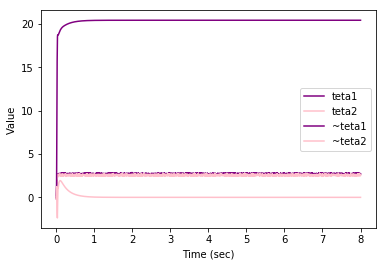

In [37]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim.trange(), sim.data[ik.probe_teta1], color = 'purple',label="teta1")
plt.plot(sim.trange(), sim.data[ik.probe_teta2], color = 'pink',label="teta2")
plt.plot(sim.trange(), sim.data[ik.probe_teta1_direct], color = 'purple',label="~teta1")
plt.plot(sim.trange(), sim.data[ik.probe_teta2_direct], color = 'pink',label="~teta2")
plt.legend()
plt.savefig('loc.jpg', dpi=350)

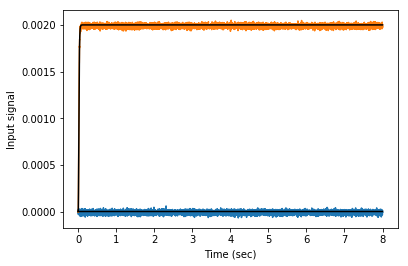

In [38]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Input signal");
plt.plot(sim.trange(), sim.data[ik.array_probe[0]])
plt.plot(sim.trange(), sim.data[ik.array_probe[1]], color = 'black')
plt.savefig('xyz.jpg', dpi=350)

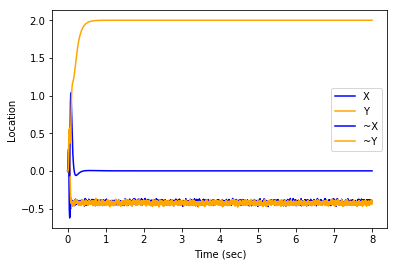

In [39]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Location");
plt.plot(sim.trange(), sim.data[ik.probe_X],label="X", color = 'blue')
plt.plot(sim.trange(), sim.data[ik.probe_Y],label="Y", color = 'orange')
plt.plot(sim.trange(), sim.data[ik.probe_X_direct],label="~X", color = 'blue')
plt.plot(sim.trange(), sim.data[ik.probe_Y_direct],label="~Y", color = 'orange')
plt.legend()
plt.savefig('loc.jpg', dpi=350)

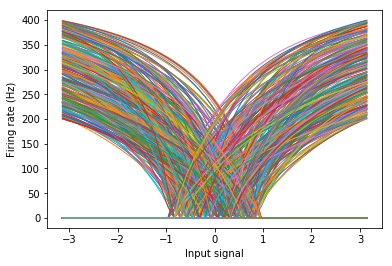

In [40]:

plt.figure()
plt.plot(eval_points, activities, lw=1)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");
